Tema: Simulação de Tráfego e Mobilidade Urbana. 

 A simulação de tráfego e mobilidade urbana é um campo de estudo que se concentra em modelar e prever o movimento dos veículos em ambientes urbanos. Este campo permite-nos analisar como diferentes políticas de trânsito podem impactar na eficiência e na sustentabilidade do sistema de transporte de uma cidade. Através da utilização de técnicas de modelagem computacional avançadas, é possível simular cenários hipotéticos e avaliar os efeitos de intervenções como a implementação de faixas exclusivas de transporte público, restrições de tráfego, expansão de redes de ciclovias e outras medidas de gestão de tráfego. Estas simulações podem fornecer informações valiosas para a tomada de decisões informadas, contribuindo para o planeamento de cidades mais acessíveis, eficientes e sustentáveis.
 
Para tal escolhemos este data set com mais 10.000 ocorrencias de trânsito. o data set localiza-se aqui:https://dados.cm-lisboa.pt/en/dataset/condicionamentos-de-transito-historico

O principal objetivo é, por exemplo, descobrir se as horas que ocorrem mais condicionamentos, o porquê de existirem e se a duração afeta o impacto.

Grupo nº6: Henrique Ponte, Miguel Carvalho & Miguel Viveiros. 

In [71]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import ast
import geopandas as gpd
from shapely.geometry import MultiLineString

dados = pd.read_csv('transito.csv')

In [72]:
dados.head(10)

,entity_id,impacto,restricao_circulacao,morada,periodos_condicionamentos,motivo,position,creation_date
0,EMEL.condicionamentoTransito.COND-2021-767-1,Relevante,Estreitamento de via,Alto da Boavista/Rotunda Pina Manique/Estrada ...,"[{'end_date': '1616011200000', 'date_min': '20...",OBRA - FAIXA DE RODAGEM,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-04 10:00:09
1,EMEL.condicionamentoTransito.COND-2021-1499-3,Pouco relevante,Estacionamento,"Avenida dos Estados Unidos da América, nº97 e 95","[{'end_date': '1616018400000', 'date_min': '20...",FILMAGENS,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-09 14:44:49
2,EMEL.condicionamentoTransito.COND-2021-1572-A-1,Relevante,Estreitamento de via,Avenida Professor Egas Moniz ft. ao CHULN/HOSP...,"[{'end_date': '1616018400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-11 12:46:02
3,EMEL.condicionamentoTransito.COND-2021-1499-4,Pouco relevante,Estacionamento,Rua Pereira Henriques entre os nºs 26 - 14,"[{'end_date': '1616018400000', 'date_min': '20...",FILMAGENS,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-09 14:47:00
4,EMEL.condicionamentoTransito.COND-2020-6258-51,Relevante,Corte total,2.ª Circular - entre o IP7 {Eixo N/S} e o ramo...,"[{'end_date': '1616047200000', 'date_min': '20...",REPAVIMENTAÇÕES,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-16 14:33:56
5,EMEL.condicionamentoTransito.COND-2020-2950-PA-24,Relevante,Estreitamento de via,"Praça dos Restauradores,79-80/Rua Jardim do Re...","[{'end_date': '1616054400000', 'date_min': '20...",CARGAS E DESCARGAS/OBRAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 17:05:34
6,EMEL.condicionamentoTransito.COND-2021-1117-12,Relevante,Mantém perfil de via,Rua do Zaire,"[{'end_date': '1616781600000', 'date_min': '20...",PINTURAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 14:07:03
7,EMEL.condicionamentoTransito.COND-2021-1117-4,Pouco relevante,Mantém perfil de via,Rua Maria Andrade,"[{'end_date': '1616781600000', 'date_min': '20...",PINTURAS,"{'type': 'GeometryCollection', 'geometries': [...",2021-02-22 13:49:38
8,EMEL.condicionamentoTransito.COND-2021-1662-A-1,Relevante,Passeio,Banco Santander Totta - Banco Santander Totta,"[{'end_date': '1616072400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-16 10:38:31
9,EMEL.condicionamentoTransito.COND-2021-1622-1,Relevante,Estreitamento de via,"Praça da Constituição de 1976, Frente à Assemb...","[{'end_date': '1616090400000', 'date_min': '20...",CONCENTRAÇÃO,"{'type': 'GeometryCollection', 'geometries': [...",2021-03-15 09:36:38


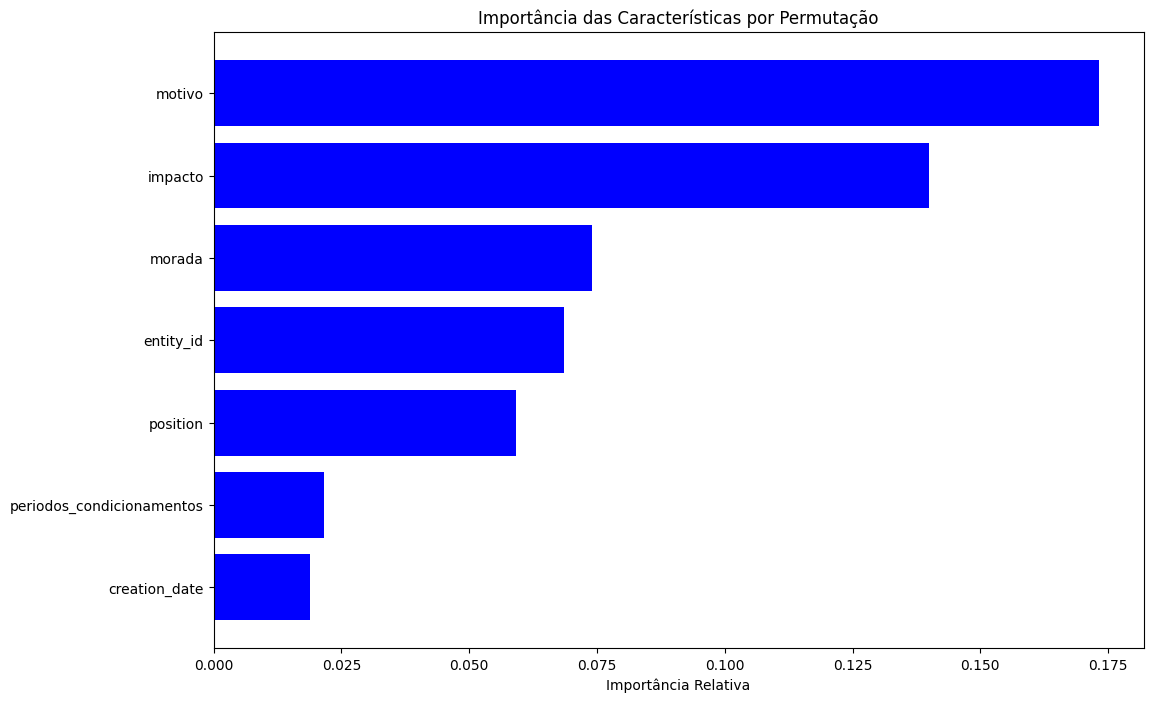

In [73]:
# Codificar as características categóricas usamos o Label enconder
encoders = {}
for col in dados.columns:
    if dados[col].dtype == 'object':
        dados[col] = dados[col].astype(str)
        
        le = LabelEncoder()
        dados[col] = le.fit_transform(dados[col])
        encoders[col] = le


coluna_alvo = 'restricao_circulacao'

# Separar as características e o alvo
X = dados.drop(coluna_alvo, axis=1)
y = dados[coluna_alvo]

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar um modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calcule a importância das características por permutação
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Obtenha a importância das características e os nomes das características
importances = result.importances_mean
feature_names = X_test.columns.tolist()

# Ordene as características pela importância
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title("Importância das Características por Permutação")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()



Os dados recolhidos apresentam 8 colunas. Com a seguinte informação:
- entity_id
  - Informação que guarda: Refere-se ao identificador do condicionamento
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- impacto
  - Informação que guarda: Refere-se ao nível de impacto na circulação (por exemplo, "Pouco relevante")
  - Escala de medida: Escala Ordinal
  - Unidade: N/A

- restricao_circulacao
  - Informação que guarda: Refere-se ao tipo de restrição à circulação (por exemplo, "Estacionamento")
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- morada
  - Informação que guarda: Refere-se à morada do condicionamento
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- periodos_condicionamentos
  - Informação que guarda: Refere-se à data de início e data de fim do condicionamento
  - Escala de medida: Escala de Intervalo
  - Unidade: Milissegundos desde a época Unix (1 de janeiro de 1970)

- motivo
  - Informação que guarda: Refere-se ao motivo do condicionamento (por exemplo, "FILMAGENS")
  - Escala de medida: Escala Nominal
  - Unidade: N/A

- position
  - Informação que guarda: Refere-se às coordenadas (latitude/longitude)
  - Escala de medida: Escala de Rácios
  - Unidade: Graus

- creation_date
  - Informação que guarda: Refere-se à data em que o condicionamento foi registado
  - Escala de medida: Escala de Intervalo
  - Unidade: Data e hora

PRÉ-PROCESSAMENTO

O pré-processamento de dados é uma etapa essencial na análise de dados e machine learning que inclui:

1. Limpeza de dados: Trata dados em falta e ruído.
2. Transformação de dados: Melhora a eficácia dos algoritmos de mineração de dados.
3. Redução de dados: Remove dados redundantes ou irrelevantes.

A escolha das técnicas depende do conjunto de dados e do problema a ser resolvido. O pré-processamento pode ser aplicado a dados estruturados, semiestruturados e não estruturados. É uma etapa que melhora a qualidade dos dados, levando a resultados mais precisos e confiáveis.

Para além da remoção dos outliers removemos as seguintes colunas entity_id e creation_date porque as mesmas não sao relevantes para a nossa análise


In [74]:
# Remover as colunas menos relevantes
dados = dados.drop(['entity_id', 'creation_date'], axis=1)

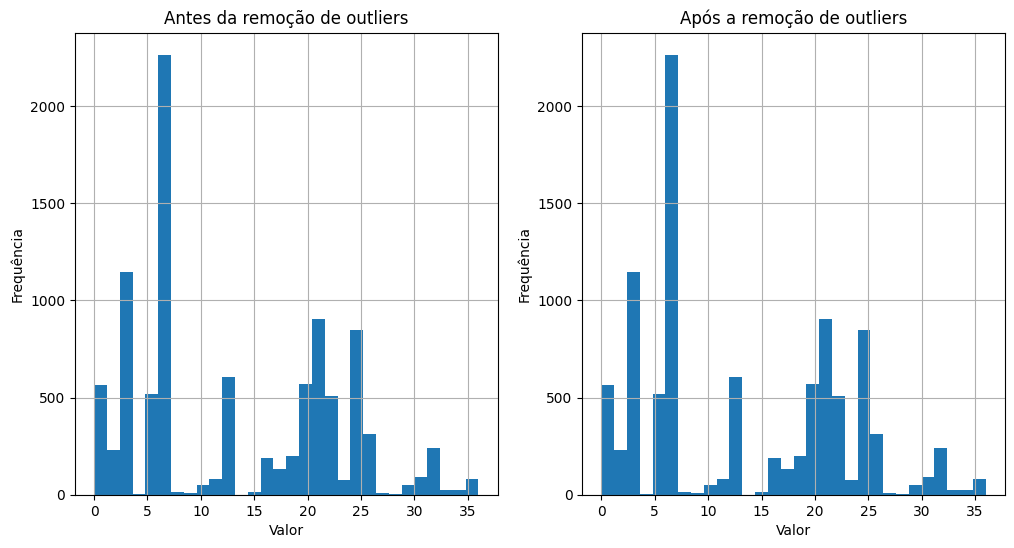

In [75]:
coluna = 'motivo'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


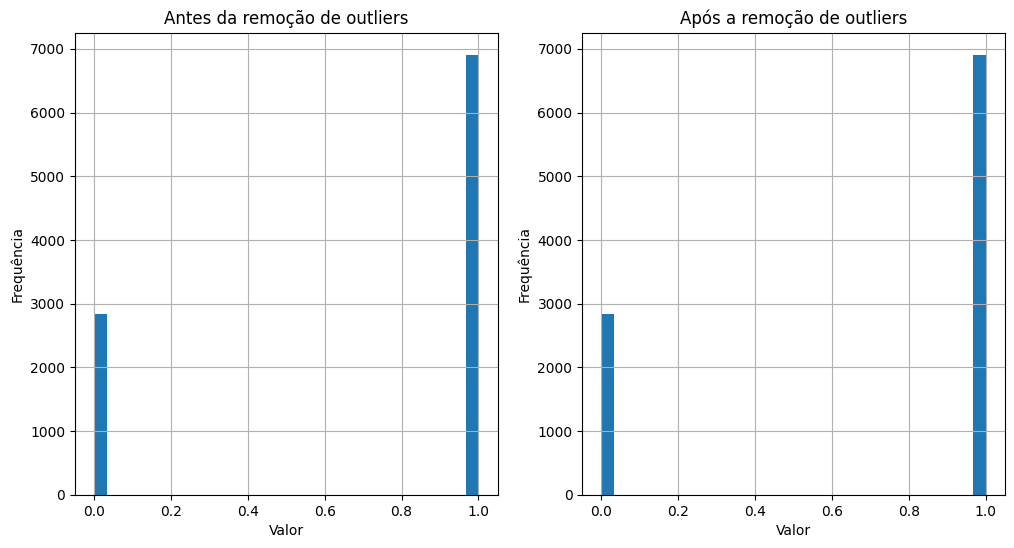

In [76]:
coluna = 'impacto'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


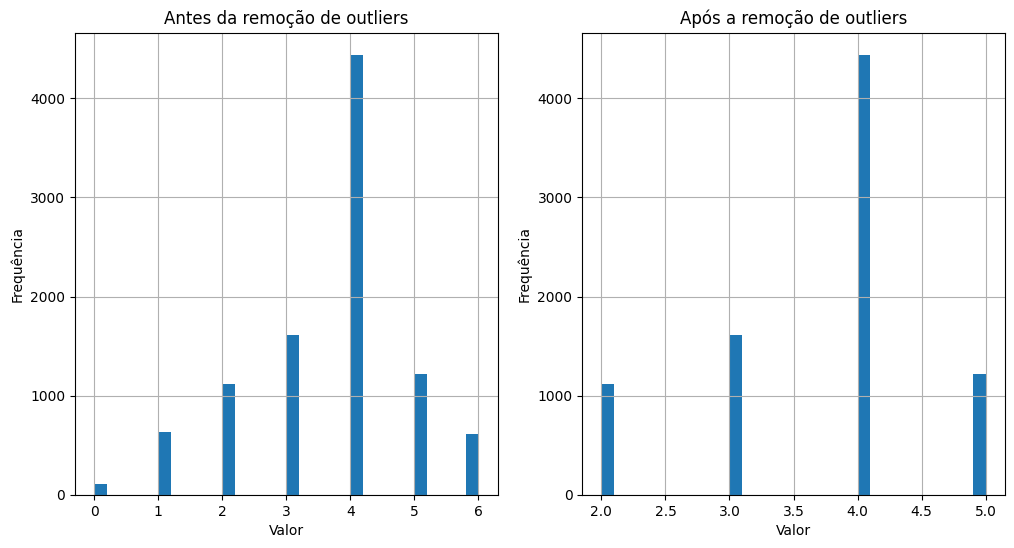

In [77]:
coluna = 'restricao_circulacao'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


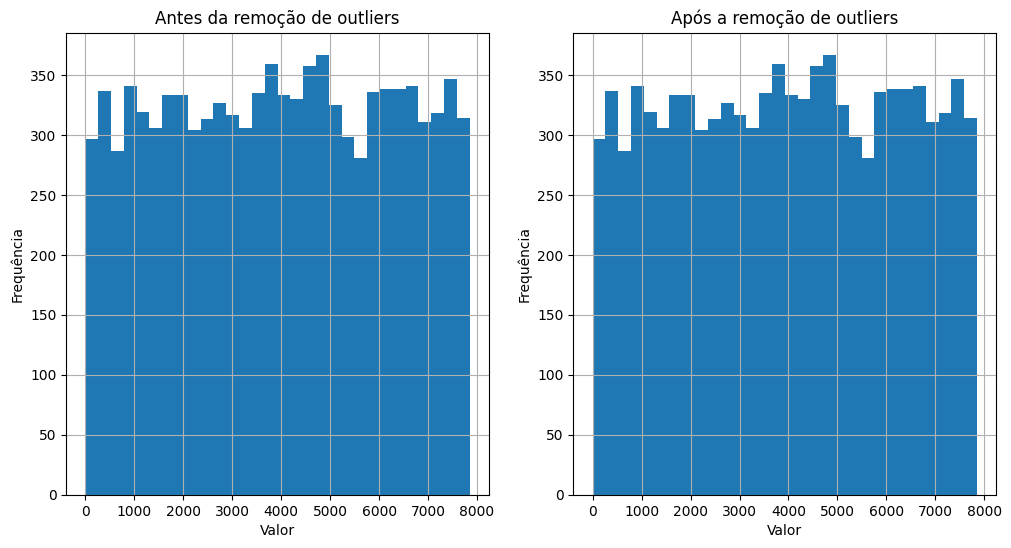

In [78]:
coluna = 'position'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


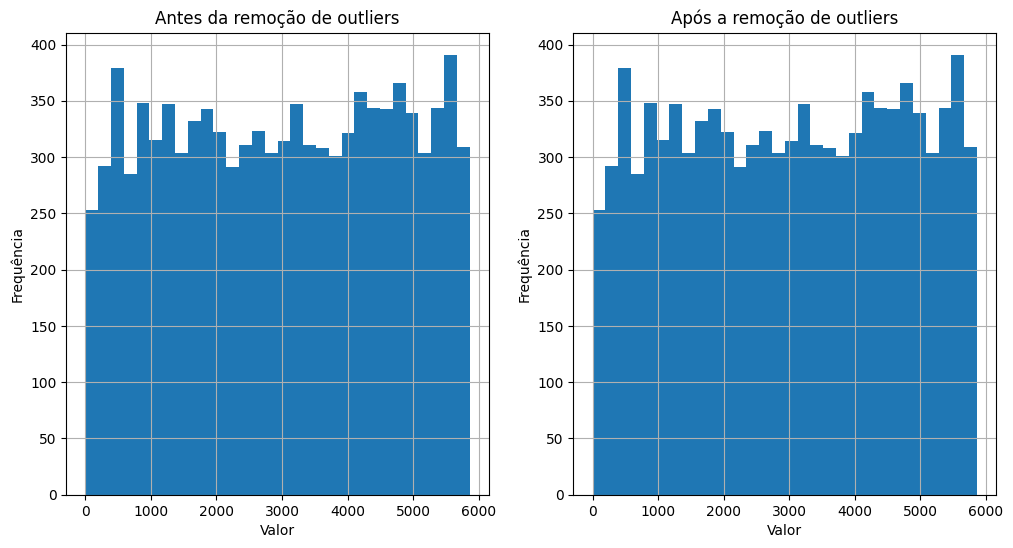

In [79]:
coluna = 'periodos_condicionamentos'

# Antes da remoção de outliers
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
dados[coluna].hist(bins=30)
plt.title('Antes da remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Remoção de outliers
Q1 = dados[coluna].quantile(0.25)
Q3 = dados[coluna].quantile(0.75)
IQR = Q3 - Q1
filtro = (dados[coluna] >= Q1 - 1.5 * IQR) & (dados[coluna] <= Q3 + 1.5 *IQR)
df_filtrado = dados.loc[filtro]

# Após a remoção de outliers
plt.subplot(1,2,2)
df_filtrado[coluna].hist(bins=30)
plt.title('Após a remoção de outliers')
plt.xlabel('Valor')
plt.ylabel('Frequência')

plt.show()


Após o tratamento dos dados inciamos por fazer alguns graficos relacionando as nossas colunas a procura de padrões e relações.

In [80]:
# Agora, para decodificar como queremos que mostre os dados categoricos e não em números
for col in dados.columns:
    if col in encoders:
        dados[col] = encoders[col].inverse_transform(dados[col])


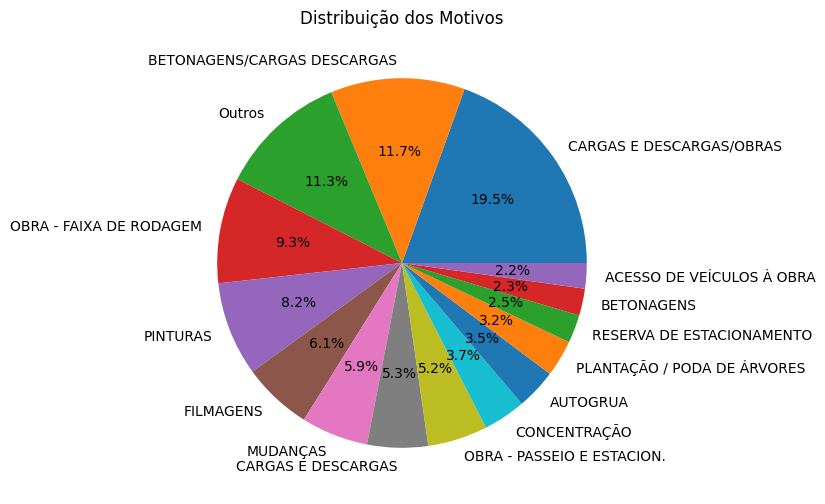

In [81]:
contagem_motivos = dados['motivo'].value_counts()

porcentagem_motivos = 100 * contagem_motivos / contagem_motivos.sum()

outros = porcentagem_motivos < 2

dados['motivo'] = dados['motivo'].where(~dados['motivo'].isin(porcentagem_motivos.index[outros]), 'Outros')

# Contar a frequência dos motivos novamente
contagem_motivos = dados['motivo'].value_counts()

# Criar o gráfico circular
plt.figure(figsize=(10, 6))
plt.pie(contagem_motivos, labels = contagem_motivos.index, autopct='%1.1f%%')
plt.title('Distribuição dos Motivos')
plt.show()

fig = px.pie(dados, names='motivo', title='Distribuição dos Motivos')
fig.show()

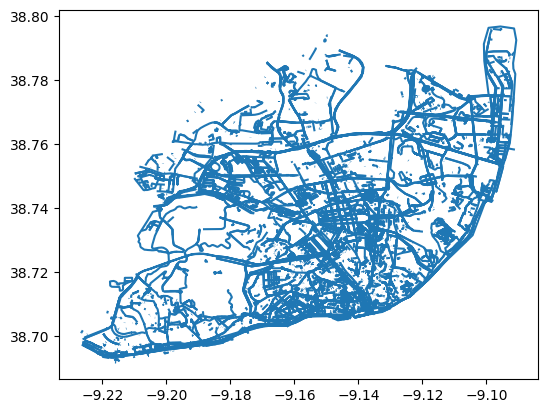

In [82]:
# Converter a coluna 'position' de string para um objeto Python (dicionário)
dados['position'] = dados['position'].apply(ast.literal_eval)

# Criar uma GeoDataFrame a partir das geometrias
gdf = gpd.GeoDataFrame(dados, geometry=[MultiLineString(geom['geometries'][0]['coordinates']) for geom in dados['position']])

# Visualizar as geometrias
gdf.plot()
plt.show()